# E-tivity 3: Clustering and Manifold Learning

Use this notebook to complete Tasks 1 and 2 in E-tivity3.

Student Name: Tom Keane

Student ID: 20214537

### Import Python Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


In [3]:
df.head()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0    0.000000         1.084523    1.058140              0.75               1   
1    0.333333         0.925883    1.047319              0.75               1   
2    0.000000         0.683858    0.635920              0.75               1   
3    0.000000         0.608992    1.002824              0.75               1   
4    0.000000         1.101869    1.115650              0.75               1   

   Gender_Male  Gender_nan  Married_Yes  Married_nan  Self_Employed_Yes  \
0            1           0            0            0                  0   
1            1           0            1            0                  0   
2            1           0            1            0                  1   
3            1           0            1            0                  0   
4            1           0            0            0                  0   

   Self_Employed_nan  Education_Not Graduate  Property_Area_Semiurban  \
0                  0                       0                        0   
1                  0                       0                        0   
2                  0                       0                        0   
3                  0                       1                        0   
4                  0                       0                        0   

   Property_Area_Urban  Loan_Status_Y  TotalIncome  
0                    1              1     0.841086  
1                    0              0     0.871711  
2                    1              1     0.385189  
3                    1              1     0.717012  
4                    1              1     0.860305

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

In [5]:
colors = np.array(['orange', 'blue', 'lime', 'cyan', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title, colors, axis):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = axis.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)
        axis.set_title(title)
        return axis

def get_details(XYcoordinates, clustered_data_sklearn, normalise=False):
    points  = min_max_scaler.fit_transform(XYcoordinates[:-k,:]) if normalise else XYcoordinates[:-k,:]
    labels  =clustered_data_sklearn.labels_
    centers =XYcoordinates[-k:,:]
    return points, labels, centers

def sum_sqr_dists(points, centers, labels):
    sqr_dists = np.array([])
    sum_sq_ds = np.array([])
    for i in range(len(centers)):
        c =  centers[i]
        p0 = points[labels==i,0]
        p1 = points[labels==i,1]
        for x, y in zip(p0, p1):
            dist = math.hypot(c[0] - x, c[1] - y)
            sqr_dists = np.append(sqr_dists, dist**2)
        sum_sq_ds = np.append(sum_sq_ds, np.sum(sqr_dists))
    for i in range(len(sum_sq_ds)):
        ssd = sum_sq_ds[i]
    return sum_sq_ds.mean()

def scatter_plot(XYcoordinates, clustered_data_sklearn, transform_title, colors, plot, axis):
    points, labels, centers = get_details(XYcoordinates, clustered_data_sklearn)
    if plot:    
        axis = clustering_scatterplot(
            points  =points, 
            labels  =labels,
            centers =centers,
            title=transform_title,
            colors=colors,
            axis=axis)
    return points, labels, centers, axis

def kmeans_analysis(k, data, df, colors, plot=True):
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16,8))
        fig.suptitle(f"k = {k}")
    else:
        axes = [1,2,3]
        print(".", end='')

    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)
    data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]
    silhouette_Score = silhouette_score(data, clustered_data_sklearn.labels_)

    XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
    points, labels, centers, axes[0] = scatter_plot(XYcoordinates, clustered_data_sklearn, 'MDS', colors, plot, axes[0])
    mean_sum_sq_ds_MDS = sum_sqr_dists(points, centers, labels)

    XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
    points, labels, centers, axes[1] = scatter_plot(XYcoordinates, clustered_data_sklearn, 't-SNE', colors, plot, axes[1])
    mean_sum_sq_ds_t_SNE = sum_sqr_dists(points, centers, labels)

    XYcoordinates = PCA(n_components=2).fit_transform(data_and_centers)
    points, labels, centers, axes[2] = scatter_plot(XYcoordinates, clustered_data_sklearn, 'PCA', colors, plot, axes[2])
    mean_sum_sq_ds_PCA = sum_sqr_dists(points, centers, labels)

    if plot:
        axes[2].legend()
        plt.show()
    if k==6:
        return  clustered_data_sklearn, {
            'k'                  : k,
            'mean_sum_sq_ds_MDS' : mean_sum_sq_ds_MDS,
            'mean_sum_sq_ds_t_SNE' : mean_sum_sq_ds_t_SNE,
            'mean_sum_sq_ds_PCA' : mean_sum_sq_ds_PCA,
            'silhouette_Score'   : silhouette_Score
    }
    else:
        return {
            'k'                  : k,
            'mean_sum_sq_ds_MDS' : mean_sum_sq_ds_MDS,
            'mean_sum_sq_ds_t_SNE' : mean_sum_sq_ds_t_SNE,
            'mean_sum_sq_ds_PCA' : mean_sum_sq_ds_PCA,
            'silhouette_Score'   : silhouette_Score
    }

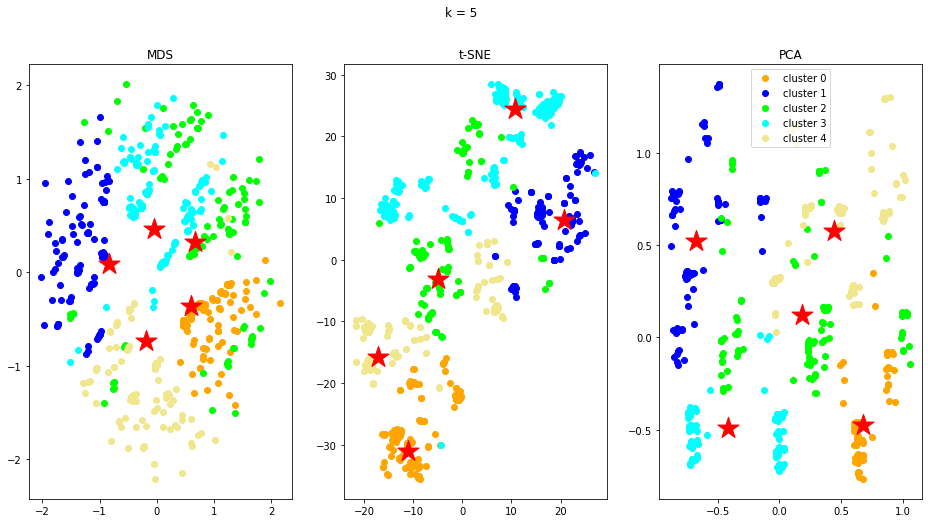

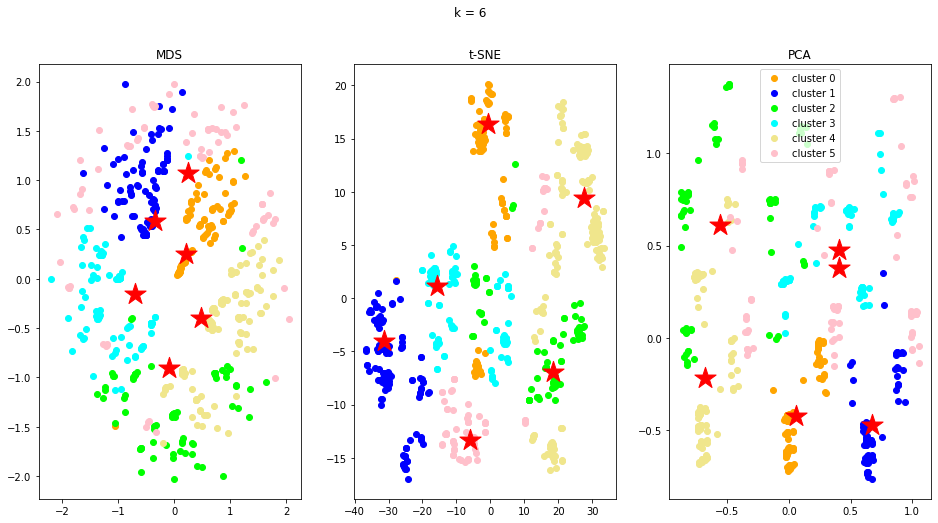

........................

In [6]:
mean_sum_sq_ds_results = {}
for k in range(2, 31):
    if k < 7:
        if k==6:
            clustered_data_sklearn_k6, mean_sum_sq_ds_results[k] = kmeans_analysis(k, data, df, colors, True)
        else:
            mean_sum_sq_ds_results[k] = kmeans_analysis(k, data, df, colors, True)
    else:
        mean_sum_sq_ds_results[k] = kmeans_analysis(k, data, df, colors, False)

I have peformed k-means analysis with three different distribution functions for k = {2..30}.
Here's some documentation on the distribution functions used.
    
[Multidimensional scaling](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS)

[t-distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)
    
[Principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)


This was quite computationally heavy, so I had to make the algorithm quite light-weight, by; 

- only keeping the the mean square distance data for each distribution function at each k-value, 

- by only printing scatter plots for k < 10.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics

In [8]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

(number of examples, number of attributes):  (614, 16)


In [9]:
try:
    min_max_scaler = preprocessing.MinMaxScaler()
    mean_sum_sq_ds_results = pd.DataFrame(mean_sum_sq_ds_results).transpose()
    mean_sum_sq_ds_results.to_csv('mean_sum_sq_ds_results.csv')
except NameError:
    print("X")
    mean_sum_sq_ds_results = pd.read_csv("./mean_sum_sq_ds_results.csv")
mean_sum_sq_ds_results
#new_header

k  mean_sum_sq_ds_MDS  mean_sum_sq_ds_t_SNE  mean_sum_sq_ds_PCA  \
2    2.0          575.144452         231841.867830          196.223970   
3    3.0          426.907241          87496.354751          131.491007   
4    4.0          290.236766          87495.642555           83.827125   
5    5.0          242.488179          55391.937795           58.424652   
6    6.0          199.726283          47764.498393           50.432773   
7    7.0          258.210445          34571.392460           41.952313   
8    8.0          214.952753          39538.111434           52.963896   
9    9.0          234.914886          30374.578875           49.658002   
10  10.0          199.892802          40998.479381           38.682482   
11  11.0          186.139128          28750.815075           43.366225   
12  12.0          146.405873          20055.434125           35.951256   
13  13.0          217.720489          17528.460067           40.415874   
14  14.0          120.972901          24671.579008           21.144614   
15  15.0          141.714652          11696.631700           21.156317   
16  16.0          155.996189          43899.912819           26.740719   
17  17.0          108.536536          15092.997615           23.292269   
18  18.0          119.655145          11243.056926           26.271290   
19  19.0          140.490824          17556.748293           23.914039   
20  20.0          176.098388          11835.584448           24.762145   
21  21.0          112.205299          10295.391254           23.128708   
22  22.0          176.937910          13728.905288           17.402795   
23  23.0          121.484435           6859.348691           22.460394   
24  24.0           95.191869           7768.504323           18.170500   
25  25.0          116.188495           6250.499089           15.373465   
26  26.0          134.611005          13598.435089           18.471732   
27  27.0          143.410321          11648.743093           25.407036   
28  28.0          107.539677          12862.222485           17.860437   
29  29.0          106.938581          16060.626057           20.259030   
30  30.0           82.258215           7917.479259           12.544094   

    silhouette_Score  
2           0.186540  
3           0.191550  
4           0.193041  
5           0.186247  
6           0.198501  
7           0.217089  
8           0.217698  
9           0.219445  
10          0.224460  
11          0.208614  
12          0.224328  
13          0.236491  
14          0.229163  
15          0.254135  
16          0.265476  
17          0.262523  
18          0.271134  
19          0.278408  
20          0.282539  
21          0.272934  
22          0.287384  
23          0.273875  
24          0.297691  
25          0.297019  
26          0.293805  
27          0.303656  
28          0.290884  
29          0.316513  
30          0.345131

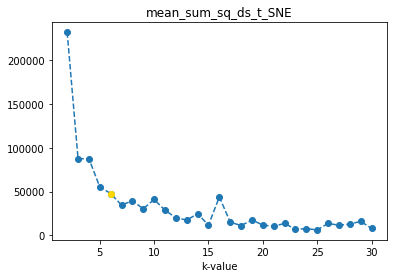

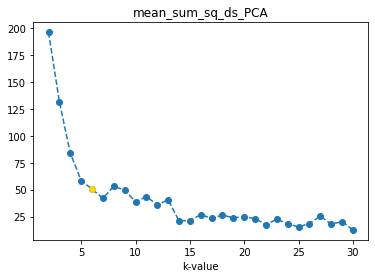

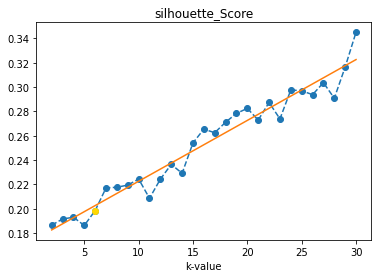

In [10]:
def plot_elbow_silhouette(df):
    for dist in df.columns:
        if dist in ['mean_sum_sq_ds_MDS', 'mean_sum_sq_ds_PCA',	'mean_sum_sq_ds_t_SNE', 'silhouette_Score']:
            plt.plot(df[dist],  marker='o', linestyle='dashed')
            plt.plot(df.loc[df['k'] == 6][dist],  marker='o', linestyle='dashed', color='gold')
            if dist=='silhouette_Score':
                plt.plot(np.unique(df['k']), np.poly1d(np.polyfit(df['k'], df[dist], 1))(np.unique(df['k'])))
            plt.xlabel('k-value')
            plt.title(dist)
            plt.show()
plot_elbow_silhouette(mean_sum_sq_ds_results)

k=3 has the most identifiable traits to my eye when looking at the plots, but the elbow plot suggests that k = {5 .. 7} would be a nice region to investigate.
The silhouette supports this decision as the coefficient tends to rise a good bit higher at the value of k=6. (not guaranteed to be illustrated in plots above due to randomness.)

All of the plots seem to support the selection of k=6 for analysis, which makes it an acceptable model.

Based on these factors, I will investigate k=6.

In [11]:
 try:
     clustered_data_sklearn = clustered_data_sklearn_k6
except:
    clustered_data_sklearn = cluster.KMeans(n_clusters=6, n_init=10, max_iter=300).fit(data)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data, clustered_data_sklearn.labels_))
df1 = df.copy()
df1['clusters'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)
df1['count'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)
round(df1.groupby(['clusters']).mean(),2)

Silhouette Coefficient: 0.199


Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
clusters                                                              
0               0.34             0.95        1.15              0.70   
1               0.36             0.94        1.10              0.68   
2               0.11             0.87        1.02              0.73   
3               0.08             0.89        1.00              0.73   
4               0.27             0.93        1.10              0.72   
5               0.29             0.89        1.08              0.72   

          Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
clusters                                                                      
0                   0.99         0.99        0.01         1.00         0.00   
1                   0.99         0.95        0.02         1.00         0.00   
2                   0.92         0.00        0.07         0.33         0.01   
3                   0.99         0.77        0.01         0.00         0.01   
4                   0.98         1.00        0.00         0.74         0.01   
5                   0.00         0.83        0.04         0.70         0.00   

          Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
clusters                                                                 
0                      0.15               0.07                    0.24   
1                      0.11               0.06                    0.19   
2                      0.16               0.07                    0.18   
3                      0.11               0.08                    0.19   
4                      0.14               0.03                    0.21   
5                      0.14               0.01                    0.33   

          Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
clusters                                                                
0                            0.00                 0.00           0.76   
1                            0.00                 1.00           0.81   
2                            0.70                 0.00           0.73   
3                            0.00                 0.61           0.70   
4                            1.00                 0.00           0.86   
5                            0.26                 0.39           0.00   

          TotalIncome  count  
clusters                      
0                0.94      0  
1                0.91      1  
2                0.74      2  
3                0.82      3  
4                0.89      4  
5                0.84      5

In [12]:
focus = ['Loan_Status_Y', 'LoanAmount', 'Education_Not Graduate', 'Dependents', 'TotalIncome', 'Property_Area_Semiurban',	'Property_Area_Urban']
print("\ndescribe Loan_Status_Y per cluster")
display(round(df1.groupby(['clusters']).describe(),2)['Loan_Status_Y'].sort_values('mean'))
display(round(df1.groupby(['clusters']).mean(),2).sort_values('Loan_Status_Y')[focus])


describe Loan_Status_Y per cluster


count  mean   std  min  25%  50%  75%  max
clusters                                            
5          76.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
3          96.0  0.70  0.46  0.0  0.0  1.0  1.0  1.0
2          83.0  0.73  0.44  0.0  0.0  1.0  1.0  1.0
0          91.0  0.76  0.43  0.0  1.0  1.0  1.0  1.0
1         113.0  0.81  0.39  0.0  1.0  1.0  1.0  1.0
4         155.0  0.86  0.35  0.0  1.0  1.0  1.0  1.0

Loan_Status_Y  LoanAmount  Education_Not Graduate  Dependents  \
clusters                                                                  
5                  0.00        1.08                    0.33        0.29   
3                  0.70        1.00                    0.19        0.08   
2                  0.73        1.02                    0.18        0.11   
0                  0.76        1.15                    0.24        0.34   
1                  0.81        1.10                    0.19        0.36   
4                  0.86        1.10                    0.21        0.27   

          TotalIncome  Property_Area_Semiurban  Property_Area_Urban  
clusters                                                             
5                0.84                     0.26                 0.39  
3                0.82                     0.00                 0.61  
2                0.74                     0.70                 0.00  
0                0.94                     0.00                 0.00  
1                0.91                     0.00                 1.00  
4                0.89                     1.00                 0.00

### Low probability of Positive Loan Status ( <= 0.1 )
From this spreadsheet, We can see that one group tends to be much less likely to have a positive loan status.
- They also tend to be slightly less likely to have be graduates than the rest, consistently highest in this category at around 0.3 non-graduates. 
- They have much worse credit history. (credit rating history stays within {0 - 0.45} for this group, while the rest tend to be in-around 0.9 range.)

Surprisingly, this groups mean total income seems to be very similar to the other groups, and often exceeds some of them in this model.
<br>______________

### Middling probability of Positive Loan Status ( ~ 0.5 - 0.75 )
These groups tend to either have a slightly lower total Income, more dependants, a high loan amount or a worse credit history than the highest likelihood of positive loan status group. There is often a mix of these factors, for example one group could have decent income at 0.9 and good credit history, but have a higher proportion of dependants than the rest, along with a high LoanAmount.
There is generally a very big gap between the lowest of these groups and the bottom group. (~0.6 gap.)
<br>______________

### High probability of Positive Loan Status ( > 0.9 )
These consistently have high income (> 0.9) and high credit history. They tend to be consistently <20% non-graduates. Their dependants and loan-amount can vary more than the other categories.
<br>______________

### Other observations regarding probability of Positive Loan Status throughout clusters
- It is noteworthy that there is usually a very low standard deviation for the lowest and highest probability groups<br>(usually 0, but high prob group can reach 0.3 std at times.)
<br><br>     In contrast, the groups in the middle tend to be more erratic. 
These middling clusters have higher standard deviations, with the highest being the second lowest probability group (~0.5), and then declining as the probability of positive loan status rises.
This tells us that these means in the middle clusters, regarding loan status are quite weak. Therefore they unfortunately may not be all that safe for use.

 - Another interesting trend is that Suburbanites are about twice as likely to have a positive loan status than rural and urban dwellers.
<br><br>     This can be gathered from the fact that the **highest probability cluster, and one middling cluster** will predominately have near **total Suburban populations**, whereas the other two middling groups are shared between **urban** and **rural** populations.

### Use another clustering algorithm (from the ones available in scikit-learn) for the same dataset and an appropriate manifold-learning technique to visualise it.

In [13]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


614x16 = 9824 data points

## [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan)
documentation:

- The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.

- The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

- There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

[useful example](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

In [14]:
from sklearn.preprocessing import StandardScaler
from matplotlib import cm

In [15]:
def performDBSCAN(data, eps, min_samples, show_noise=False):
    # data = StandardScaler().fit_transform(data)
    db = cluster.DBSCAN(n_jobs=-1, eps=eps, min_samples=min_samples).fit(data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_noise_, n_clusters_ = examine_DBSCAN(data, labels)
    # Black removed and is used for noise instead.
    plot(
        data=data,
        core_samples_mask=core_samples_mask,
        n_clusters_=n_clusters_,
        labels=labels,
        eps=eps,
        min_samples=min_samples,
        show_noise=show_noise)
    return

def examine_DBSCAN(data, labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(data, labels))
    return n_noise_, n_clusters_

def plot(data, core_samples_mask, labels, n_clusters_, eps, min_samples, show_noise=False):
    fig, axes = plt.subplots(1, 3, figsize=(16,8))
    fig.suptitle('Estimated number of clusters: %d' % n_clusters_)

    distributions_of_data = make_distributions(data)
    for dist_data, axis in zip(distributions_of_data, axes):
        axis.set_title(f"{dist_data}")
        for lab, col in prepare_labels(labels):
            if lab == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels == lab)
            xy = distributions_of_data[dist_data][class_member_mask & core_samples_mask]
            axis.plot(xy[:, 0], xy[:, 1], 'o', c=tuple(col),
                     markersize=14, label=f"cluster {lab}")

            if show_noise:
                xy = distributions_of_data[dist_data][class_member_mask & ~core_samples_mask]
                axis.plot(xy[:, 0], xy[:, 1], '.', c=tuple(col),
                        markersize=14)
    axis.legend()
    plt.show()

def make_distributions(data):
    MDS_dist_data = manifold.MDS(n_components=2).fit_transform(data)
    TSNE_dist_data= manifold.TSNE(n_components=2).fit_transform(data)
    PCA_dist_data = PCA(n_components=2).fit_transform(data)
    return {
        'MDS'  :MDS_dist_data,
        'TSNE' :TSNE_dist_data,
        'PCA'  :PCA_dist_data}

def prepare_labels(labels):
    unique_labels = np.unique(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    return list(zip(unique_labels, colors))

I will vary the mininmum samples per group, and the eps value, which dictates the distance between a value and a cluster.
Higher min_samples or lower eps indicate higher density necessary to form a cluster.

min_samples = 4  eps = 1.0
Estimated number of clusters: 34
Estimated number of noise points: 169
Silhouette Coefficient: 0.156


min_samples = 4  eps = 0.9
Estimated number of clusters: 34
Estimated number of noise points: 185
Silhouette Coefficient: 0.146


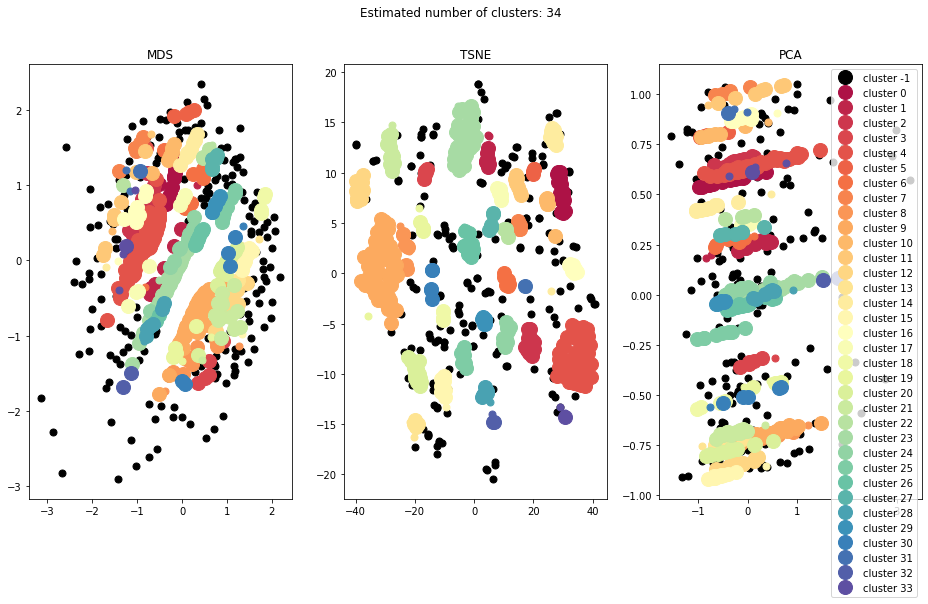

min_samples = 4  eps = 0.8
Estimated number of clusters: 33
Estimated number of noise points: 200
Silhouette Coefficient: 0.133


min_samples = 4  eps = 0.7000000000000001
Estimated number of clusters: 31
Estimated number of noise points: 225
Silhouette Coefficient: 0.113


min_samples = 6  eps = 1.0
Estimated number of clusters: 28
Estimated number of noise points: 204
Silhouette Coefficient: 0.120


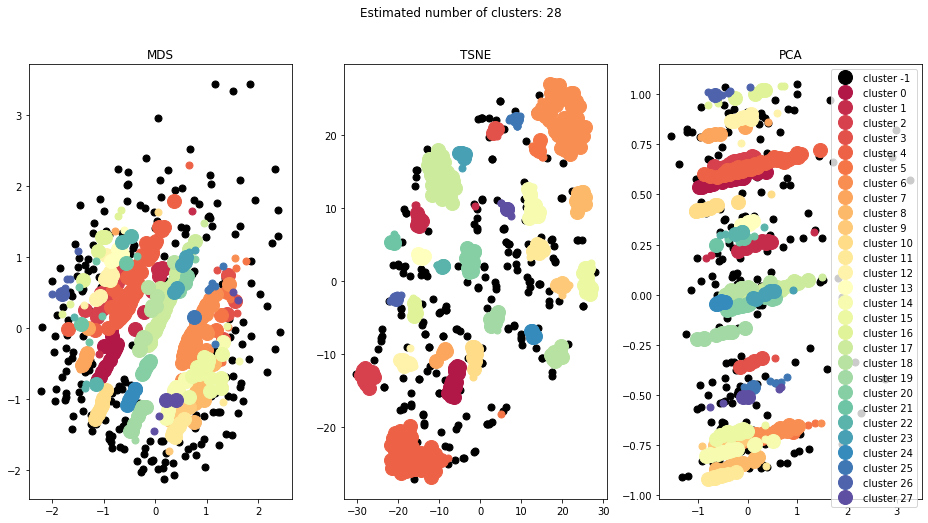

min_samples = 6  eps = 0.9
Estimated number of clusters: 27
Estimated number of noise points: 218
Silhouette Coefficient: 0.111


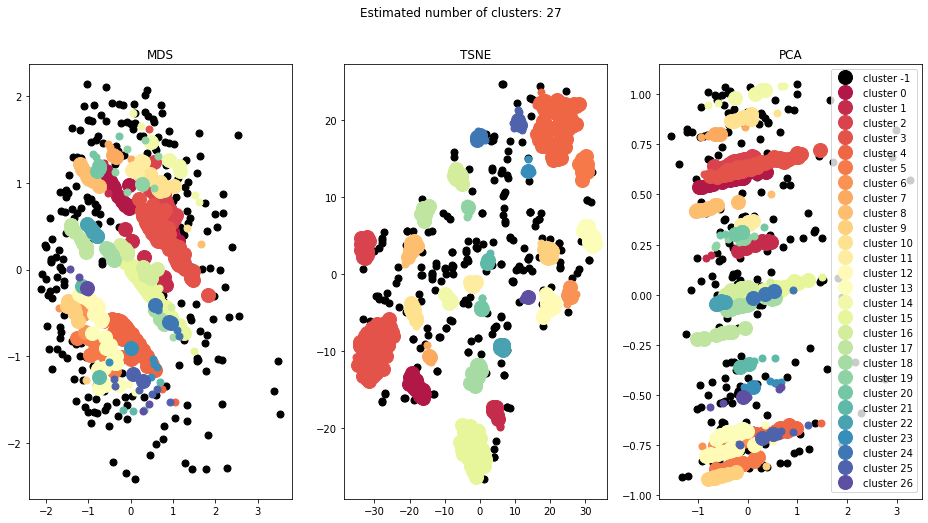

min_samples = 6  eps = 0.8
Estimated number of clusters: 25
Estimated number of noise points: 242
Silhouette Coefficient: 0.088


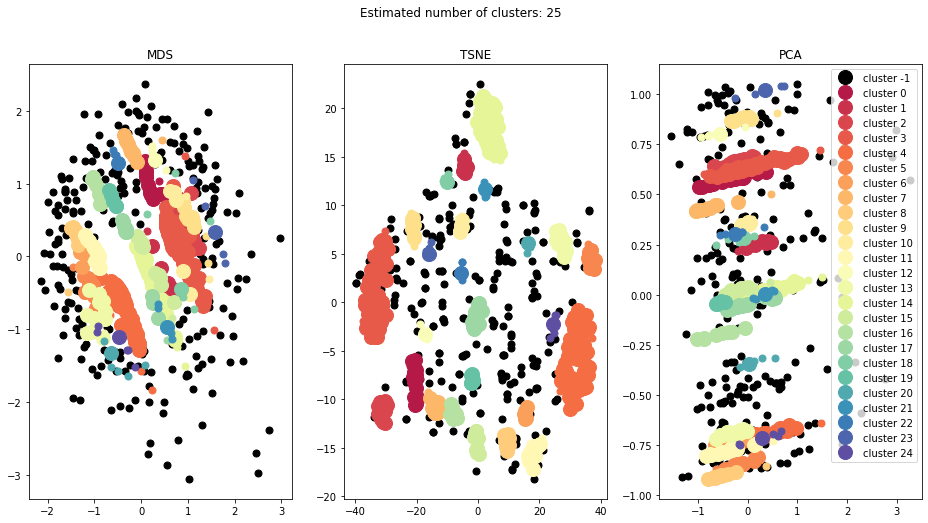

min_samples = 6  eps = 0.7000000000000001
Estimated number of clusters: 19
Estimated number of noise points: 288
Silhouette Coefficient: 0.046


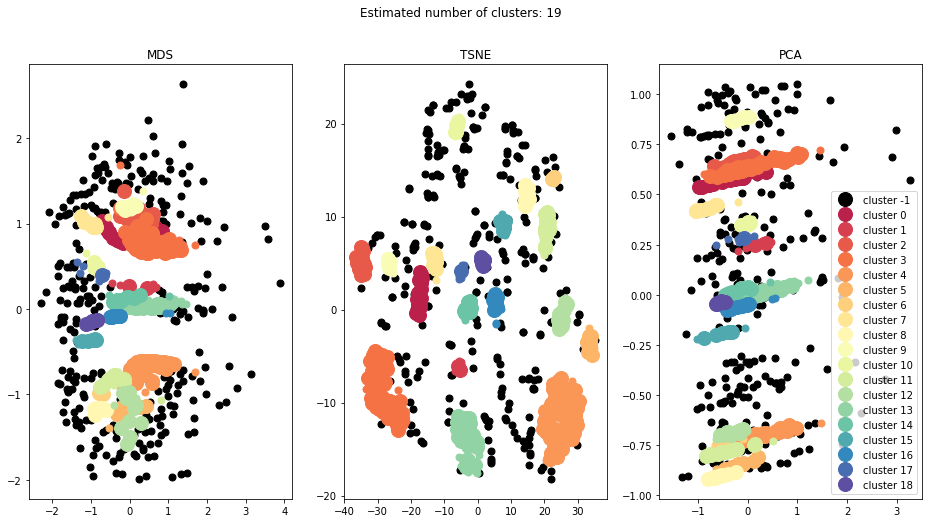

min_samples = 8  eps = 1.0
Estimated number of clusters: 17
Estimated number of noise points: 278
Silhouette Coefficient: 0.055


min_samples = 8  eps = 0.9
Estimated number of clusters: 17
Estimated number of noise points: 285
Silhouette Coefficient: 0.052


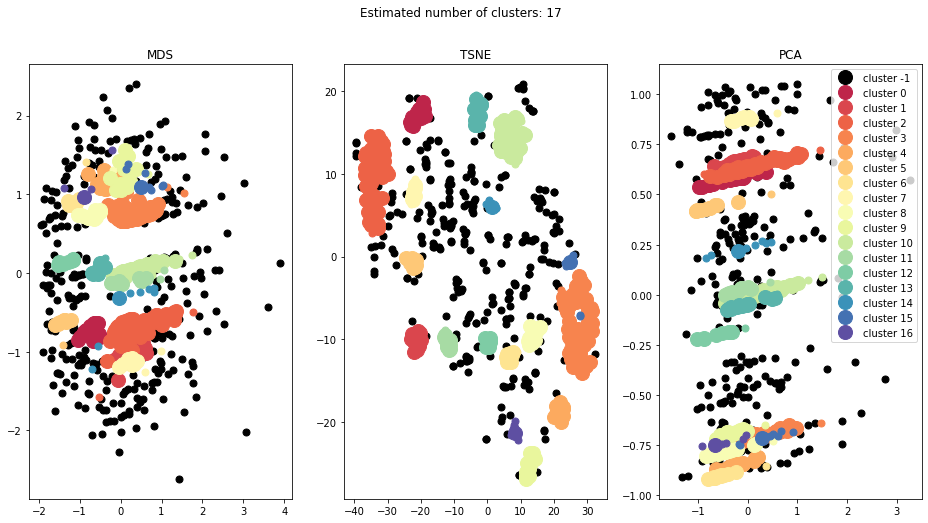

min_samples = 8  eps = 0.8
Estimated number of clusters: 14
Estimated number of noise points: 312
Silhouette Coefficient: 0.028


min_samples = 8  eps = 0.7000000000000001
Estimated number of clusters: 13
Estimated number of noise points: 329
Silhouette Coefficient: 0.016


In [16]:
for min_samples in np.arange(4, 9, 2):
    for eps in np.arange(1, 0.7, -0.1):
        print(f"min_samples = {min_samples}  eps = {eps}")
        performDBSCAN(data, eps=eps, min_samples=min_samples, show_noise=True)

It seems  that the most useful results are found at eps=1, min_samples=6. There are 

In [17]:
db = cluster.DBSCAN(n_jobs=-1, eps=1, min_samples=6).fit(data)

print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data, db.labels_))
df1 = df.copy()
df1['clusters'] = pd.Series(db.labels_, index=df.index)
df1['count'] = pd.Series(db.labels_, index=df.index)
round(df1.groupby(['clusters']).mean(),2)

Silhouette Coefficient: 0.120


Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
clusters                                                              
-1              0.23             1.02        1.13              0.70   
 0              0.02             0.84        0.93              0.71   
 1              0.17             0.87        1.19              0.69   
 2              0.40             0.75        1.00              0.67   
 3              0.72             0.85        1.13              0.71   
 4              0.33             0.93        1.07              0.68   
 5              0.40             1.09        1.15              0.75   
 6              0.27             0.90        1.12              0.74   
 7              0.00             0.83        0.94              0.82   
 8              0.15             0.72        0.99              0.70   
 9              0.17             0.78        0.89              0.69   
 10             0.03             0.79        0.81              0.72   
 11             0.03             0.85        0.95              0.75   
 12             0.37             0.87        1.03              0.75   
 13             0.33             0.79        1.09              0.70   
 14             0.04             0.74        0.95              0.74   
 15             0.47             0.68        0.93              0.68   
 16             0.25             0.91        1.11              0.75   
 17             0.30             0.91        1.13              0.70   
 18             0.39             0.78        1.06              0.75   
 19             0.13             0.75        0.98              0.78   
 20             0.17             0.96        1.14              0.75   
 21             0.52             0.76        0.98              0.70   
 22             0.22             1.00        1.01              0.75   
 23             0.48             0.96        1.11              0.67   
 24             0.00             0.83        0.81              0.75   
 25             0.33             0.96        1.31              0.70   
 26             0.11             0.72        0.89              0.73   
 27             0.06             1.07        1.14              0.79   

          Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
clusters                                                                      
-1                  0.73         0.61        0.06         0.49         0.01   
 0                  1.00         1.00        0.00         0.00         0.00   
 1                  1.00         1.00        0.00         1.00         0.00   
 2                  1.00         1.00        0.00         1.00         0.00   
 3                  0.00         1.00        0.00         1.00         0.00   
 4                  1.00         1.00        0.00         1.00         0.00   
 5                  1.00         1.00        0.00         1.00         0.00   
 6                  1.00         1.00        0.00         1.00         0.00   
 7                  1.00         1.00        0.00         0.00         0.00   
 8                  1.00         0.00        0.00         1.00         0.00   
 9                  1.00         1.00        0.00         0.00         0.00   
 10                 1.00         0.00        0.00         0.00         0.00   
 11                 1.00         0.00        0.00         0.00         0.00   
 12                 1.00         0.90        0.00         1.00         0.00   
 13                 0.00         1.00        0.00         1.00         0.00   
 14                 1.00         1.00        0.00         0.00         0.00   
 15                 1.00         1.00        0.00         1.00         0.00   
 16                 0.00         1.00        0.00         1.00         0.00   
 17                 1.00         1.00        0.00         1.00         0.00   
 18                 1.00         1.00        0.00         1.00         0.00   
 19                 1.00         0.00        0.00         0.00        

In [18]:
focus = ['Loan_Status_Y', 'LoanAmount', 'Education_Not Graduate', 'Dependents', 'TotalIncome', 'Property_Area_Semiurban',	'Property_Area_Urban']
print("\ndescribe Loan_Status_Y per cluster")
focus_df_means = round(df1.groupby(['clusters']).mean(),2).sort_values('Loan_Status_Y')[focus]
# display(focus_df)


describe Loan_Status_Y per cluster


In [19]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(focus_df_means, annot=True)

<AxesSubplot:ylabel='clusters'>

Again, we can verify that suburban residents are much more likely to have a positive loan status.  (looks like it could be by a factor of about 2)

It looks like positive loan outcomes become much less likely after loanAmount exceeds 1.1. A high loanAmount appears to be a leading contributor to negative loan status, though it is certainly not a sole contributor.

Income seems to be about evenly distributed against positive loan status.

Unfortunately, DBSCAN appears to have been a rather unsuitable model for this data-set.
The silhouette coefficient rarely exeeds 0.1, and never exceeds 0.2.
The noise-points are consistently greater than half the data-set.

And in analysis, it was difficult to see anything that wasn't already displayed by the k-means analysis.

